# Testing Mistral OCR 2503 Model

In this notebook, we try a new model that's been launched, namely [Mistral OCR 2503](https://mistral.ai/news/mistral-ocr).

This model argues that it has one of the stronger character recognitions with the in-built LLM base. 

This means that the model first understands the content of the uploaded document and then extracts the information.

![Mistral OCR Benchmark](mistral_benchmark.png)




In [1]:
# Library Imports

import os
import json
import io
import base64
from pathlib import Path

import pandas as pd
import fitz  # PyMuPDF
from PIL import Image
from dotenv import load_dotenv, find_dotenv
from IPython.display import Markdown, display

from mistralai import Mistral, DocumentURLChunk, ImageURLChunk, TextChunk
from openai import AzureOpenAI

In [2]:
# Set the client up

load_dotenv(find_dotenv())
api_key = os.getenv("MISTRAL_API_KEY_AXIANS")
mistral_client = Mistral(api_key=api_key)


In [3]:
def extract_page_and_ocr(pdf_path: Path, page_number: int) -> str:
    """
    Extracts a single page from a PDF, uploads it to Mistral OCR, and returns combined markdown.

    Args:
        pdf_path (Path): Path to the PDF file.
        page_number (int): Page number to extract (1-based).

    Returns:
        str: Combined markdown string (with embedded base64 images).
    """
    # Validate inputs
    if not pdf_path.is_file():
        raise FileNotFoundError(f"PDF file not found: {pdf_path}")
    
    doc = fitz.open(pdf_path)
    page_index = page_number - 1
    if page_index >= len(doc):
        raise IndexError(f"PDF only has {len(doc)} pages. Requested: {page_number}")

    # Extract and save the page
    new_doc = fitz.open()
    new_doc.insert_pdf(doc, from_page=page_index, to_page=page_index, widgets=False)
    output_path = pdf_path.parent / f"page_{page_number}_only.pdf"
    new_doc.save(output_path)
    new_doc.close()

    # Upload to OCR
    uploaded_file = mistral_client.files.upload(
        file={
            "file_name": output_path.stem,
            "content": output_path.read_bytes(),
        },
        purpose="ocr",
    )
    signed_url = mistral_client.files.get_signed_url(file_id=uploaded_file.id, expiry=1)

    # Run OCR
    pdf_response = mistral_client.ocr.process(
        document=DocumentURLChunk(document_url=signed_url.url),
        model="mistral-ocr-latest",
        include_image_base64=True,
    )

    # Parse OCR output into markdown with inline images
    def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
        for img_name, base64_str in images_dict.items():
            markdown_str = markdown_str.replace(
                f"![{img_name}]({img_name})", f"![{img_name}]({base64_str})"
            )
        return markdown_str

    def get_combined_markdown(ocr_response) -> str:
        markdowns = []
        for page in ocr_response.pages:
            image_data = {img.id: img.image_base64 for img in page.images}
            markdowns.append(replace_images_in_markdown(page.markdown, image_data))
        return "\n\n".join(markdowns)

    combined_md = get_combined_markdown(pdf_response)

    display(Markdown(combined_md))

    return combined_md


In [4]:
markdown_output = extract_page_and_ocr(Path("data/example_2.pdf"), 211)


| Borehole/ Location | Depth Range | Unit Weight ${ }_{T}$ |  | Pore Pressure Adjustment Factor K |
| :--: | :--: | :--: | :--: | :--: |
|  | $[\mathrm{m}]$ | $\begin{gathered} \text { Ground } \\ {\left[\mathrm{kN} / \mathrm{m}^{3}\right]} \end{gathered}$ | Ground Water $\left[\mathrm{kN} / \mathrm{m}^{3}\right]$ |  |
| CPT_WFS4_2 | $\begin{aligned} & 0.00 \text { to } 0.80 \\ & 0.80 \text { to } 10.65 \\ & 10.65 \text { to } 24.50 \\ & 24.50 \text { to } 27.10 \\ & 27.10 \text { to } 27.75 \\ & 27.75 \text { to } 33.40 \\ & 33.40 \text { to } 34.90 \\ & 34.90 \text { to } 38.10 \\ & 38.10 \text { to bottom } \end{aligned}$ | $\begin{aligned} & 20.00 \\ & 20.50 \\ & 20.00 \\ & 19.50 \\ & 19.50 \\ & 19.50 \\ & 19.50 \\ & 19.50 \\ & 18.50 \\ & 20.00 \end{aligned}$ | 10.0 | - |
| CPT_WFS4_3 | $\begin{aligned} & 0.00 \text { to } 6.80 \\ & 6.80 \text { to } 11.00 \\ & 11.00 \text { to } 20.95 \\ & 20.95 \text { to } 23.30 \\ & 23.30 \text { to } 23.90 \\ & 23.90 \text { to } 28.20 \\ & 28.20 \text { to } 30.65 \\ & 30.65 \text { to } 34.35 \\ & 34.35 \text { to bottom } \end{aligned}$ | $\begin{aligned} & 20.00 \\ & 20.50 \\ & 20.00 \\ & 19.50 \\ & 19.50 \\ & 19.50 \\ & 19.50 \\ & 19.50 \\ & 20.00 \end{aligned}$ | 10.0 | - |
| CPT_WFS4_4 | $\begin{aligned} & 0.00 \text { to } 0.90 \\ & 0.90 \text { to } 9.60 \\ & 9.60 \text { to } 12.25 \\ & 12.25 \text { to } 14.45 \\ & 14.45 \text { to } 17.50 \\ & 17.50 \text { to bottom } \end{aligned}$ | $\begin{aligned} & 20.00 \\ & 20.50 \\ & 20.00 \\ & 20.00 \\ & 20.00 \\ & 20.00 \end{aligned}$ | 10.0 | - |
| CPT_WFS4_5 | $\begin{aligned} & 0.00 \text { to } 2.45 \\ & 2.45 \text { to } 12.30 \\ & 12.30 \text { to } 15.50 \\ & 15.50 \text { to } 24.80 \\ & 24.80 \text { to bottom } \end{aligned}$ | $\begin{aligned} & 20.00 \\ & 20.50 \\ & 20.50 \\ & 20.00 \\ & 20.00 \end{aligned}$ | 10.0 | - |
| CPT_WFS4_6 | $\begin{aligned} & 0.00 \text { to } 4.90 \\ & 4.90 \text { to } 12.60 \\ & 12.60 \text { to } 14.35 \\ & 14.35 \text { to } 17.10 \\ & 17.10 \text { to } 19.75 \\ & 19.75 \text { to bottom } \end{aligned}$ | $\begin{aligned} & 20.00 \\ & 20.50 \\ & 20.50 \\ & 20.50 \\ & 20.50 \\ & 20.50 \\ & 20.50 \end{aligned}$ | 10.0 | - |
| CPT_WFS4_8 | $\begin{aligned} & 0.00 \text { to } 1.80 \\ & 1.80 \text { to } 12.20 \\ & 12.20 \text { to } 13.90 \\ & 13.90 \text { to } 15.90 \\ & 15.90 \text { to } 19.70 \\ & 19.70 \text { to bottom } \end{aligned}$ | $\begin{aligned} & 20.00 \\ & 20.50 \\ & 19.50 \\ & 19.50 \\ & 18.50 \\ & 20.00 \end{aligned}$ | 10.0 | - |
| CPT_WFS4_9 | $\begin{aligned} & 0.00 \text { to } 3.50 \\ & 3.50 \text { to bottom } \end{aligned}$ | $\begin{aligned} & 20.00 \\ & 20.50 \\ & 19.50 \\ & 19.50 \\ & 18.50 \\ & 20.00 \end{aligned}$ | 10.0 | - |

Note:

1. The adjustment factor K applies only to probes with a pore pressure filter in the face of the cone.

# PARAMETER VALUES FOR NET CONE RESISTANCE CALCULATION

In [5]:
markdown_output = extract_page_and_ocr(Path("data/example_3.pdf"), 261)

| Project: | Van Wyck Expressway Widening | Project No.: | 187802 |
| :--: | :--: | :--: | :--: |
| Client: | NYSDOT | Location: | Van Wyck Expressway |
| Install Date: | 4/20/2018 | Boring No.: | PT-X-02 |
| Inspector: | Gabriela de Aragao | Hours: | 8:30 AM 12:35 PM |
| Contractor: | Warren George, Inc. | Weather: | Partly Cloudy |
| Driller/Helper | Jim Wilson, Eddie Fontanez | Temperature: | AM 37 deg F. $\quad$ PM 51 deg F. |

Installation and Stratigraphy Sketch:

|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  |  |  | Casing O.D. |  |  |  |  | Casing Size: |  |  |  |  |  | HW |  |  |  |
|  |  |  |  |  |  |  |  | Casing I.D.: |  |  |  |  | 4.0 | in. |  |  |  |
|  |  |  |  |  | $\Delta$ |  |  | Casing O.D.: |  |  |  |  | 4.5 | in. |  |  |  |
|  |  |  |  |  | $\Delta$ Casing Stickup |  |  | Casing Stickup above ground: |  |  |  | 2.5 | ft. |  |  |  |  |
| Ground Surface |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  | Ground Elev.: |  |  |  |  | 32.0 | ft. |  |  |  |
|  |  |  |  |  |  |  |  | (See additional remarks below) |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  | Test Depth Below Ground |  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  | Drainage Material: |  |  | clean coarse sand: |  |  |  |  |  |
|  |  |  |  |  |  |  |  | Drainage Thickness: |  |  |  |  | 4 | in. |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  | Depth to Drainage Layer: |  |  |  |  | 7.7 | ft. |  |  |  |
| Drainage Material |  |  |  |  |  |  |  | Elevation at Top Drainage Layer: |  |  |  | 24.4 | ft. |  |  |  |  |
|  |  |  |  |  |  | Drainage Thickness |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  | Depth to Casing Bottom: |  |  |  |  | 8.0 | ft. |  |  |  |
|  |  |  |  |  |  |  |  | Elevation at Casing Bottom: |  |  |  |  | 24.0 | ft. |  |  |  |
|  |  |  | Diagram Not to Scale |  |  |  |  | (See additional remarks below) |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
| Percolation Test Readings: |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
| Test <br> No. | Date <br> Start | Date <br> Finish | Time <br> Start | Time <br> Finish | Test <br> Depth <br> (ft.) |  | Length of Time Internal (min.) |  | Water Depth at Start Time Interval (in.) |  | Water Depth at End Time Interval (in.) |  | Drop in Water Level (in.) |  | Percolation Rate (in./hr.) |  |
| 1 | 4/20/18 | 4/20/18 | 8:30 | 8:45 | 8.0 |  | 15 | 99.2 |  | 99.5 |  | 0.2 |  |  |  | 1.4 |
|  | 4/20/18 | 4/20/18 | 8:45 | 9:00 | 8.0 |  | 15 | 99.5 |  | 99.8 |  | 0.4 |  |  |  |  |
|  | 4/20/18 | 4/20/18 | 9:00 | 9:15 | 8.0 |  | 15 | 99.8 |  | 100.3 |  | 0.5 |  |  |  |  |
|  | 4/20/18 | 4/20/18 | 9:15 | 9:30 | 8.0 |  | 15 | 100.3 |  | 100.7 |  | 0.4 |  |  |  |  |
| 2 | 4/20/18 | 4/20/18 | 9:35 | 9:50 | 8.0 |  | 15 | 99.0 |  | 99.4 |  | 0.4 |  |  |  | 1.3 |
|  | 4/20/18 | 4/20/18 | 9:50 | 10:05 | 8.0 |  | 15 | 99.4 |  | 99.8 |  | 0.5 |  |  |  |  |
|  | 4/20/18 | 4/20/18 | 10:05 | 10:35 | 8.0 |  | 30 | 99.8 |  | 100.3 |  | 0.5 |  |  |  |  |
| 3 | 4/20/18 | 4/20/18 | 10:35 | 10:55 | 8.0 |  | 20 | 99.7 |  | 100.0 |  | 0.2 |  |  |  | 1.0 |
|  | 4/20/18 | 4/20/18 | 10:55 | 11:15 | 8.0 |  | 20 | 100.0 |  | 100.2 |  | 0.2 |  |  |  |  |
|  | 4/20/18 | 4/20/18 | 11:15 | 11:35 | 8.0 |  | 20 | 100.2 |  | 100.7 |  | 0.5 |  |  |  |  |
| 4 | 4/20/18 | 4/20/18 | 11:35 | 11:55 | 8.0 |  | 20 | 99.6 |  | 100.0 |  | 0.4 |  |  |  | 1.1 |
|  | 4/20/18 | 4/20/18 | 11:55 | 12:15 | 8.0 |  | 20 | 100.0 |  | 100.3 |  | 0.4 |  |  |  |  |
|  | 4/20/18 | 4/20/18 | 12:15 | 12:35 | 8.0 |  | 20 | 100.3 |  | 100.7 |  | 0.4 |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
| Additional Remarks: |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
| 1 | Test depth recorded below existing ground surface. |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
| 2 | Depth to water level measured below the top of the casing. |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
| 3 | Elevation is reported on the North American Vertical Datum of 1988 (NAVD 88) in U.S. Survey feet. |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |

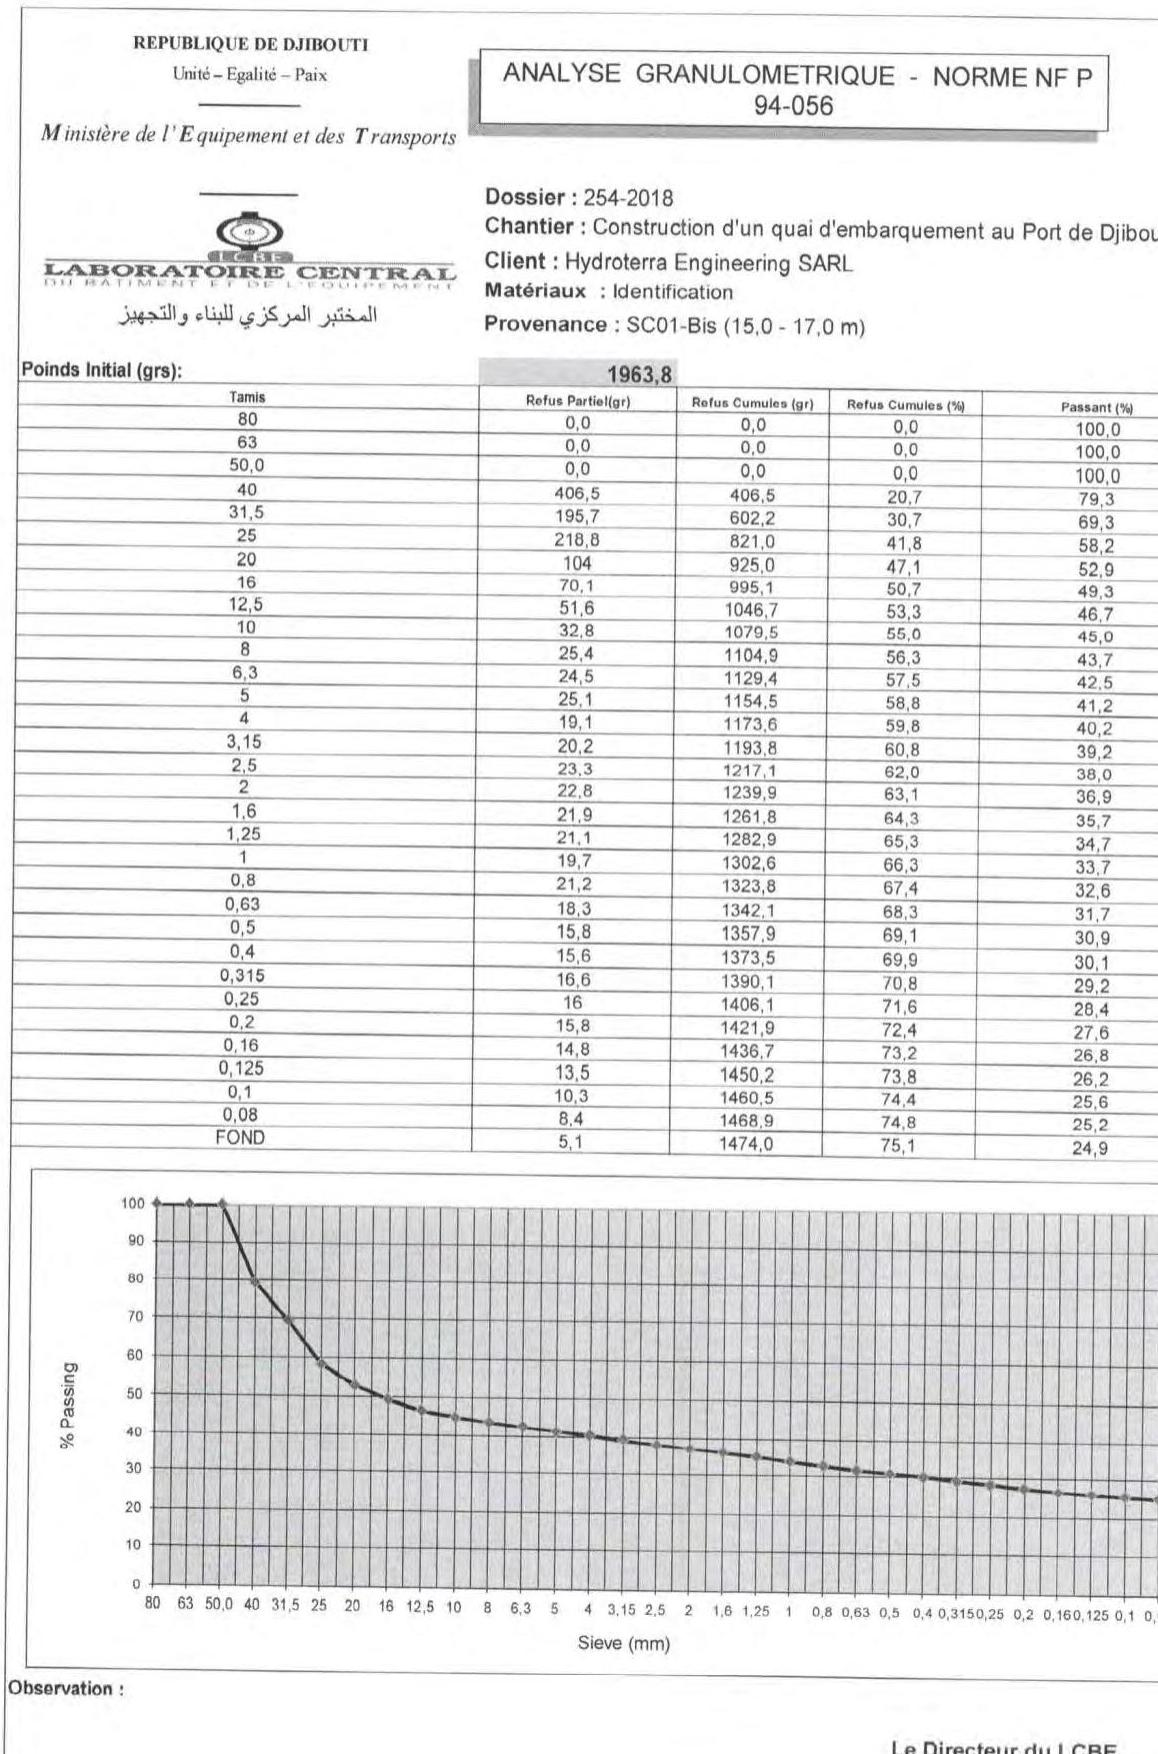

In [6]:
markdown_output = extract_page_and_ocr(Path("data/example_1.pdf"), 21)


# Try with OpenAI GPT-Vision 4

In [15]:

# Load environment
load_dotenv(find_dotenv())
gpt_client = AzureOpenAI(
    azure_endpoint=os.getenv("ENDPOINT_URL"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2024-05-01-preview",
)
model = os.getenv("DEPLOYMENT_NAME")



def extract_pdf_page_as_base64_image(pdf_path: Path, page_number: int) -> str:
    """
    Extract a PDF page and return it as a base64-encoded PNG image string.
    """
    doc = fitz.open(pdf_path)
    page_index = page_number - 1
    if page_index >= len(doc):
        raise IndexError(f"PDF has only {len(doc)} pages. Requested: {page_number}")

    pix = doc[page_index].get_pixmap(dpi=300)
    image = Image.open(io.BytesIO(pix.tobytes()))

    buffer = io.BytesIO()
    image.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode()


def analyze_pdf_page_with_gpt_vision(client: gpt_client, model: str, pdf_path: Path, page_number: int, prompt: str) -> str:
    """
    Use GPT-4 Vision to analyze a specific page of a PDF using a custom prompt.
    """
    base64_image = extract_pdf_page_as_base64_image(pdf_path, page_number)

    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{base64_image}",
                            "detail": "high"
                        },
                    },
                ],
            }
        ],
        max_tokens=1500,
        temperature=0.2,
    )

    
    response = response.choices[0].message.content.strip()
    
    
    display(Markdown(response))

    return response


In [ ]:

analyze_pdf_page_with_gpt_vision(
    client=gpt_client,
    model=model,
    pdf_path=Path("data/example_2.pdf"),
    page_number=211,
    prompt="Extract any tables and present them in markdown. If there are no tables, summarize the key points on the page."
)


Here is the extracted table presented in markdown format:

```markdown
| Borehole/ Location | Depth Range [m]       | Unit Weight γ [kN/m³] | Ground [kN/m³] | Ground Water [kN/m³] | Pore Pressure Adjustment Factor K [-] |
|--------------------|-----------------------|------------------------|-----------------|-----------------------|---------------------------------------|
| CPT_WFS4_2         | 0.00 to 0.80          | 20.00                  | 20.00           | 10.0                  | ---                                   |
|                    | 0.80 to 10.65         | 20.50                  |                 |                       |                                       |
|                    | 10.65 to 24.50        | 20.00                  |                 |                       |                                       |
|                    | 24.50 to 27.10        | 19.50                  |                 |                       |                                       |
|                    | 27.10 to 27.75        | 19.50                  |                 |                       |                                       |
|                    | 27.75 to 33.40        | 19.50                  |                 |                       |                                       |
|                    | 33.40 to 34.90        | 19.50                  |                 |                       |                                       |
|                    | 34.90 to 38.10        | 18.50                  |                 |                       |                                       |
|                    | 38.10 to bottom       | 20.00                  |                 |                       |                                       |
| CPT_WFS4_3         | 0.00 to 6.80          | 20.00                  | 20.00           | 10.0                  | ---                                   |
|                    | 6.80 to 11.00         | 20.50                  |                 |                       |                                       |
|                    | 11.00 to 20.95        | 20.00                  |                 |                       |                                       |
|                    | 20.95 to 23.30        | 19.50                  |                 |                       |                                       |
|                    | 23.30 to 23.90        | 19.50                  |                 |                       |                                       |
|                    | 23.90 to 28.20        | 19.50                  |                 |                       |                                       |
|                    | 28.20 to 30.65        | 19.50                  |                 |                       |                                       |
|                    | 30.65 to 34.35        | 19.50                  |                 |                       |                                       |
|                    | 34.35 to bottom       | 20.00                  |                 |                       |                                       |
| CPT_WFS4_4         | 0.00 to 0.90          | 20.00                  | 20.00           | 10.0                  | ---                                   |
|                    | 0.90 to 9.60          | 20.50                  |                 |                       |                                       |
|                    | 9.60 to 12.25         | 20.00                  |                 |                       |                                       |
|                    | 12.25 to 14.45        | 20.00                  |                 |                       |                                       |
|                    | 14.45 to 17.50        | 20.00                  |                 |                       |                                       |
|                    | 17.50 to bottom       | 20.00                  |                 |                       |                                       |
| CPT_WFS4_5         | 0.00 to 2.45          | 20.00                  | 20.00           | 10.0                  | ---                                   |
|                    | 2.45 to 12.30         | 20.50                  |                 |                       |                                       |
|                    | 12.30 to 15.50        | 20.50                  |                 |                       |                                       |
|                    | 15.50 to 24.80        | 20.00                  |                 |                       |                                       |
|                    | 24.80 to bottom       | 20.00                  |                 |                       |                                       |
| CPT_WFS4_6         | 0.00 to 4.90          | 20.00                  | 20.00           | 10.0                  | ---                                   |
|                    | 4.90 to 12.60         | 20.50                  |                 |                       |                                       |
|                    | 12.60 to 14.35        | 20.50                  |                 |                       |                                       |
|                    | 14.35 to 17.10        | 20.50                  |                 |                       |                                       |
|                    | 17.10 to 19.75        | 20.50                  |                 |                       |                                       |
|                    | 19.75 to bottom       | 20.50                  |                 |                       |                                       |
| CPT_WFS4_8         | 0.00 to 1.80          | 20.00                  | 20.00           | 10.0                  | ---                                   |
|                    | 1.80 to 12.20         | 20.50                  |                 |                       |                                       |
|                    | 12.20 to 13.90        | 19.50                  |                 |                       |                                       |
|                    | 13.90 to 15.90        | 19.50                  |                 |                       |                                       |
|                    | 15.90 to 19.70        | 18.50                  |                 |                       |                                       |
|                    | 19.70 to bottom       | 20.00                  |                 |                       |                                       |
| CPT_WFS4_9         | 0.00 to 3.50          | 20.00                  | 20.00           | 10.0                  | ---                                   |
|                    | 3.50 to bottom        | 20.50                  |                 |                       |                                       |

**Note:** The adjustment factor K applies only to probes with a pore pressure filter in the face of the cone.
```

This table summarizes the parameter values for net cone resistance calculation at various borehole locations within the Borssele Wind Farm Zone, WFS IV - Dutch Sector, North Sea.

'Here is the extracted table presented in markdown format:\n\n```markdown\n| Borehole/ Location | Depth Range [m]       | Unit Weight γ [kN/m³] | Ground [kN/m³] | Ground Water [kN/m³] | Pore Pressure Adjustment Factor K [-] |\n|--------------------|-----------------------|------------------------|-----------------|-----------------------|---------------------------------------|\n| CPT_WFS4_2         | 0.00 to 0.80          | 20.00                  | 20.00           | 10.0                  | ---                                   |\n|                    | 0.80 to 10.65         | 20.50                  |                 |                       |                                       |\n|                    | 10.65 to 24.50        | 20.00                  |                 |                       |                                       |\n|                    | 24.50 to 27.10        | 19.50                  |                 |                       |                                       |

In [18]:

analyze_pdf_page_with_gpt_vision(
    client=gpt_client,
    model=model,
    pdf_path=Path("data/example_3.pdf"),
    page_number=263,
    prompt="Extract any tables and present them in markdown. If there are no tables, summarize the key points on the page."
)


Here is the extracted table from the Percolation Test Report presented in markdown format:

```markdown
| Test No. | Date Start | Date Finish | Time Start | Time Finish | Test Depth (ft.) | Length of Time Interval (min.) | Water Depth at Start Time Interval (in.) | Water Depth at End Time Interval (in.) | Drop in Water Level (in.) | Percolation Rate (in/hr.) |
|----------|------------|-------------|------------|-------------|------------------|-------------------------------|------------------------------------------|----------------------------------------|---------------------------|---------------------------|
| 1        | 4/18/18    | 4/18/18     | 13:22      | 13:32       | 8.0              | 10                            | 87.1                                     | 87.8                                   | 0.7                       | 4.1                       |
| 2        | 4/18/18    | 4/18/18     | 13:32      | 13:52       | 8.0              | 20                            | 87.8                                     | 89.3                                   | 1.4                       | 3.0                       |
| 3        | 4/18/18    | 4/18/18     | 13:52      | 14:22       | 8.0              | 30                            | 89.3                                     | 91.2                                   | 1.9                       | 3.0                       |
| 4        | 4/18/18    | 4/18/18     | 14:22      | 14:32       | 8.0              | 10                            | 91.2                                     | 91.8                                   | 0.6                       | 3.5                       |
| 5        | 4/18/18    | 4/18/18     | 14:32      | 14:52       | 8.0              | 20                            | 91.8                                     | 92.6                                   | 0.8                       | 3.0                       |
| 6        | 4/18/18    | 4/18/18     | 14:52      | 15:22       | 8.0              | 30                            | 92.6                                     | 94.7                                   | 2.0                       | 3.0                       |
| 7        | 4/18/18    | 4/18/18     | 15:22      | 15:26       | 8.0              | 60                            | 94.7                                     | 97.7                                   | 3.0                       | 3.0                       |
| 8        | 4/18/18    | 4/18/18     | 16:22      | 17:22       | 8.0              | 60                            | 97.7                                     | 100.7                                  | 3.0                       | 3.0                       |

| Minimum (in/hr.) | Maximum (in/hr.) | Average (in/hr.) |
|------------------|------------------|-------------------|
| 3.0              | 4.1              | 3.4               |
```

### Key Points:
- **Project Information**: The report is for the Van Wyck Expressway Widening project, conducted for NYSDOT.
- **Installation Date**: The percolation test was conducted on April 18, 2018.
- **Test Depth**: The test was performed at a depth of 8.0 ft.
- **Water Depth Measurements**: The water depth was recorded at various intervals, showing fluctuations in water levels.
- **Percolation Rates**: The percolation rates varied from a minimum of 3.0 in/hr to a maximum of 4.1 in/hr, with an average rate of 3.4 in/hr.
- **Additional Remarks**: The test depth was recorded below the existing ground surface, and the elevation is reported based on the North American Vertical Datum of 1988 (NAVD 88).

'Here is the extracted table from the Percolation Test Report presented in markdown format:\n\n```markdown\n| Test No. | Date Start | Date Finish | Time Start | Time Finish | Test Depth (ft.) | Length of Time Interval (min.) | Water Depth at Start Time Interval (in.) | Water Depth at End Time Interval (in.) | Drop in Water Level (in.) | Percolation Rate (in/hr.) |\n|----------|------------|-------------|------------|-------------|------------------|-------------------------------|------------------------------------------|----------------------------------------|---------------------------|---------------------------|\n| 1        | 4/18/18    | 4/18/18     | 13:22      | 13:32       | 8.0              | 10                            | 87.1                                     | 87.8                                   | 0.7                       | 4.1                       |\n| 2        | 4/18/18    | 4/18/18     | 13:32      | 13:52       | 8.0              | 20                          

In [19]:

analyze_pdf_page_with_gpt_vision(
    client=gpt_client,
    model=model,
    pdf_path=Path("data/example_1.pdf"),
    page_number=21,
    prompt="Extract any tables and present them in markdown. If there are no tables, summarize the key points on the page."
)


Here is the extracted table presented in markdown format:

```markdown
| Tamis (mm) | Refus Partiel (gr) | Refus Cumule (gr) | Refus Cumule (%) | Passant (%) |
|------------|---------------------|--------------------|-------------------|-------------|
| 80         | 0.0                 | 0.0                | 0.0               | 100.0       |
| 63         | 0.0                 | 0.0                | 0.0               | 100.0       |
| 50         | 0.0                 | 0.0                | 0.0               | 100.0       |
| 31.5       | 40.6                | 40.6               | 20.7              | 79.3        |
| 25         | 195.7               | 602.2              | 30.7              | 69.3        |
| 20         | 218.0               | 821.0              | 41.8              | 58.2        |
| 16         | 10.4                | 925.0              | 47.1              | 52.9        |
| 12.5       | 70.1                | 995.1              | 50.7              | 49.3        |
| 10         | 51.8                | 1046.7             | 53.3              | 46.7        |
| 8          | 32.8                | 1079.5             | 56.3              | 43.7        |
| 6.3        | 24.5                | 1104.9             | 57.8              | 42.2        |
| 5          | 25.1                | 1129.4             | 58.8              | 41.2        |
| 3.15       | 17.5                | 1173.6             | 60.8              | 39.2        |
| 2.5        | 20.2                | 1193.8             | 60.8              | 39.2        |
| 2          | 23.3                | 1217.1             | 62.3              | 36.0        |
| 1.6        | 21.9                | 1261.8             | 64.3              | 35.7        |
| 1.25       | 21.7                | 1282.6             | 65.3              | 34.7        |
| 1          | 19.7                | 1302.6             | 66.3              | 33.7        |
| 0.83       | 21.2                | 1332.8             | 67.4              | 32.6        |
| 0.5        | 15.8                | 1347.6             | 68.3              | 31.7        |
| 0.4        | 15.6                | 1357.9             | 69.0              | 30.9        |
| 0.315      | 16.6                | 1390.1             | 71.6              | 28.9        |
| 0.25       | 0.2                 | 1401.6             | 71.8              | 28.4        |
| 0.2        | 15.8                | 1421.9             | 72.4              | 27.6        |
| 0.16       | 14.8                | 1436.7             | 73.2              | 26.8        |
| 0.125      | 13.5                | 1450.2             | 73.8              | 26.2        |
| 0.1        | 10.3                | 1460.5             | 74.4              | 25.6        |
| 0.08       | 8.4                 | 1489.8             | 74.8              | 25.2        |
| FOND       | 5.1                 | 1474.0             | 75.1              | 24.9        |
```

### Key Points:
- The table presents the results of a granulometric analysis for a construction project at the Port of Djibouti.
- It includes various sieve sizes (in mm) and their corresponding weights retained, cumulative weights, and percentages passing through the sieves.
- The analysis indicates the distribution of particle sizes in the material tested, which is crucial for understanding its suitability for construction purposes.

'Here is the extracted table presented in markdown format:\n\n```markdown\n| Tamis (mm) | Refus Partiel (gr) | Refus Cumule (gr) | Refus Cumule (%) | Passant (%) |\n|------------|---------------------|--------------------|-------------------|-------------|\n| 80         | 0.0                 | 0.0                | 0.0               | 100.0       |\n| 63         | 0.0                 | 0.0                | 0.0               | 100.0       |\n| 50         | 0.0                 | 0.0                | 0.0               | 100.0       |\n| 31.5       | 40.6                | 40.6               | 20.7              | 79.3        |\n| 25         | 195.7               | 602.2              | 30.7              | 69.3        |\n| 20         | 218.0               | 821.0              | 41.8              | 58.2        |\n| 16         | 10.4                | 925.0              | 47.1              | 52.9        |\n| 12.5       | 70.1                | 995.1              | 50.7              | 49.3        |

# Try with Mistral LLM

In [20]:
def extract_page_and_chat_with_mistral(
    pdf_path: Path,
    page_number: int,
    client,
    model="pixtral-12b-latest"
) -> str:
    """
    Extracts a PDF page, uploads to signed URL service, and uses Mistral chat API with document_url.
    Returns response as Markdown-formatted string.
    """

    # 1. Extract the page
    doc = fitz.open(pdf_path)
    page_index = page_number - 1
    if page_index >= len(doc):
        raise IndexError(f"Page {page_number} out of range. PDF has {len(doc)} pages.")

    output_path = pdf_path.parent / f"page_{page_number}_only.pdf"
    new_doc = fitz.open()
    new_doc.insert_pdf(doc, from_page=page_index, to_page=page_index, widgets=False)
    new_doc.save(output_path)
    new_doc.close()

    # 2. Upload and get signed URL
    uploaded_file = client.files.upload(
        file={
            "file_name": output_path.name,
            "content": output_path.read_bytes(),
        },
        purpose="ocr"
    )
    signed_url = client.files.get_signed_url(file_id=uploaded_file.id, expiry=1)

    # 3. Call chat with document_url and markdown-focused prompt
    messages = [
        {
            "role": "user",
            "content": [
                DocumentURLChunk(document_url=signed_url.url),
                TextChunk(
                    text="Extract any tables and present them in markdown. If there are no tables, summarize the key points on the page."
                )
            ]
        }
    ]

    response = client.chat.complete(
        model=model,
        messages=messages,
        temperature=0.3
    )

    markdown_output = response.choices[0].message.content
    
    display(Markdown(markdown_output))
    return markdown_output


In [ ]:
extract_page_and_chat_with_mistral(
    pdf_path=Path("data/example_3.pdf"),
    page_number=261,
    client=mistral_client,
    model="pixtral-12b-latest"
)



Certainly! Below are the tables extracted from the document presented in markdown format:

### Installation and Stratigraphy Sketch

|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  |  |  | Casing O.D. |  |  |  |  | Casing Size: |  |  |  |  |  | HW |  |  |  |
|  |  |  |  |  |  |  |  | Casing I.D.: |  |  |  |  | 4.0 | in. |  |  |  |
|  |  |  |  |  |  |  |  | Casing O.D.: |  |  |  |  | 4.5 | in. |  |  |  |
|  |  |  |  |  |  |  |  | Casing Stickup above ground: |  |  |  | 2.5 | ft. |  |  |  |  |
| Ground Surface |  |  |  |  |  |  |  | Ground Elev.: |  |  |  |  | 32.0 | ft. |  |  |  |
|  |  |  |  |  |  |  |  | (See additional remarks below) |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  | Test Depth Below Ground |  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  | Drainage Material: |  |  | clean coarse sand: |  |  |  |  |  |
|  |  |  |  |  |  |  |  | Drainage Thickness: |  |  |  |  | 4 | in. |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  | Depth to Drainage Layer: |  |  |  |  | 7.7 | ft. |  |  |  |
| Drainage Material |  |  |  |  |  |  |  | Elevation at Top Drainage Layer: |  |  |  | 24.4 | ft. |  |  |  |  |
|  |  |  |  |  |  | Drainage Thickness |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  | Depth to Casing Bottom: |  |  |  |  | 8.0 | ft. |  |  |  |
|  |  |  |  |  |  |  |  | Elevation at Casing Bottom: |  |  |  |  | 24.0 | ft. |  |  |  |
|  |  |  | Diagram Not to Scale |  |  |  |  | (See additional remarks below) |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |

### Percolation Test Readings

| Test <br> No. | Date <br> Start | Date <br> Finish | Time <br> Start | Time <br> Finish | Test <br> Depth <br> (ft.) | Length of Time Internal (min.) | Water Depth at Start Time Interval (in.) | Water Depth at End Time Interval (in.) | Drop in Water Level (in.) | Percolation Rate (in./hr.) |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| 1 | 4/20/18 | 4/20/18 | 8:30 | 8:45 | 8.0 | 15 | 99.2 | 99.5 | 0.2 | 1.4 |
|  | 4/20/18 | 4/20/18 | 8:45 | 9:00 | 8.0 | 15 | 99.5 | 99.8 | 0.4 |  |
|  | 4/20/18 | 4/20/18 | 9:00 | 9:15 | 8.0 | 15 | 99.8 | 100.3 | 0.5 |  |
|  | 4/20/18 | 4/20/18 | 9:15 | 9:30 | 8.0 | 15 | 100.3 | 100.7 | 0.4 |  |
| 2 | 4/20/18 | 4/20/18 | 9:35 | 9:50 | 8.0 | 15 | 99.0 | 99.4 | 0.4 | 1.3 |
|  | 4/20/18 | 4/20/18 | 9:50 | 10:05 | 8.0 | 15 | 99.4 | 99.8 | 0.5 |  |
|  | 4/20/18 | 4/20/18 | 10:05 | 10:35 | 8.0 | 30 | 99.8 | 100.3 | 0.5 |  |
| 3 | 4/20/18 | 4/20/18 | 10:35 | 10:55 | 8.0 | 20 | 99.7 | 100.0 | 0.2 | 1.0 |
|  | 4/20/18 | 4/20/18 | 10:55 | 11:15 | 8.0 | 20 | 100.0 | 100.2 | 0.2 |  |
|  | 4/20/18 | 4/20/18 | 11:15 | 11:35 | 8.0 | 20 | 100.2 | 100.7 | 0.5 |  |
| 4 | 4/20/18 | 4/20/18 | 11:35 | 11:55 | 8.0 | 20 | 99.6 | 100.0 | 0.4 | 1.1 |
|  | 4/20/18 | 4/20/18 | 11:55 | 12:15 | 8.0 | 20 | 100.0 | 100.3 | 0.4 |  |
|  | 4/20/18 | 4/20/18 | 12:15 | 12:35 | 8.0 | 20 | 100.3 | 100.7 | 0.4 |  |

### Additional Remarks

1. Test depth recorded below existing ground surface.
2. Depth to water level measured below the top of the casing.
3. Elevation is reported on the North American Vertical Datum of 1988 (NAVD 88) in U.S. Survey feet.

'Certainly! Below are the tables extracted from the document presented in markdown format:\n\n### Installation and Stratigraphy Sketch\n\n|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |\n| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |\n|  |  |  | Casing O.D. |  |  |  |  | Casing Size: |  |  |  |  |  | HW |  |  |  |\n|  |  |  |  |  |  |  |  | Casing I.D.: |  |  |  |  | 4.0 | in. |  |  |  |\n|  |  |  |  |  |  |  |  | Casing O.D.: |  |  |  |  | 4.5 | in. |  |  |  |\n|  |  |  |  |  |  |  |  | Casing Stickup above ground: |  |  |  | 2.5 | ft. |  |  |  |  |\n| Ground Surface |  |  |  |  |  |  |  | Ground Elev.: |  |  |  |  | 32.0 | ft. |  |  |  |\n|  |  |  |  |  |  |  |  | (See additional remarks below) |  |  |  |  |  |  |  |  |  |\n|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |\n|  |  |  |  |  | Test Depth Below Ground |  |  |  |  |  |  |  |  |  |  |  |  |\n|  |  |  |  |  |  |  |  |  |

In [22]:
extract_page_and_chat_with_mistral(
    pdf_path=Path("data/example_1.pdf"),
    page_number=21,
    client=mistral_client,
    model="pixtral-12b-latest"
)



Certainly! Below is the extracted table from the document presented in markdown format:

```markdown
# Analyse Granulometrique - Norme NF P 94-056

**Dossier:** 254-2018
**Chantier:** Construction d’un quai d’embarquement au Port de Djibouti
**Client:** Hydraterra Engineering SARL
**Matériaux:** Identification
**Provenance:** SC01-Bis (15.0 - 17.0 m)

**Poids Initial (grs): 1963.8**

| Tamis (mm) | Refus Particulier (g) | Refus Cumulé (g) | Refus Cumulé (%) | Passant (%) |
|------------|------------------------|------------------|------------------|-------------|
| 80         | 0.0                    | 0.0              | 0.0              | 100.0       |
| 63         | 0.0                    | 0.0              | 0.0              | 100.0       |
| 50         | 0.0                    | 0.0              | 0.0              | 100.0       |
| 40         | 406.6                  | 406.6            | 20.7             | 79.3        |
| 31.5       | 195.7                  | 602.3            | 30.7             | 69.3        |
| 25         | 218.0                  | 821.0            | 41.8             | 58.2        |
| 20         | 104                    | 925.0            | 47.1             | 52.9        |
| 16         | 70.1                   | 995.1            | 50.7             | 49.3        |
| 12.5       | 51.6                   | 1046.7           | 53.3             | 46.7        |
| 10         | 37.8                   | 1084.5           | 55.0             | 45.0        |
| 8          | 25.4                   | 1104.9           | 56.9             | 43.1        |
| 6.3        | 24.5                   | 1129.4           | 57.6             | 42.4        |
| 5          | 25.1                   | 1154.5           | 58.8             | 41.2        |
| 4          | 19.1                   | 1173.6           | 59.6             | 40.4        |
| 3.15       | 20.2                   | 1193.8           | 60.8             | 39.2        |
| 2.5        | 18.5                   | 1212.3           | 62.0             | 38.0        |
| 2          | 22.8                   | 1235.1           | 63.7             | 36.3        |
| 1.6        | 21.9                   | 1261.8           | 64.3             | 35.7        |
| 1.25       | 21.1                   | 1282.9           | 65.3             | 34.7        |
| 1          | 19.7                   | 1302.6           | 66.3             | 33.7        |
| 0.8        | 21.2                   | 1323.8           | 67.4             | 32.6        |
| 0.6        | 16.3                   | 1340.1           | 68.3             | 31.7        |
| 0.5        | 15.6                   | 1355.7           | 69.1             | 30.9        |
| 0.4        | 15.6                   | 1371.3           | 69.6             | 30.4        |
| 0.315      | 10.6                   | 1380.1           | 70.6             | 30.0        |
| 0.25       | 16                    | 1406.1           | 71.6             | 28.4        |
| 0.2        | 15.6                   | 1421.0           | 72.4             | 27.6        |
| 0.16       | 14.8                   | 1435.8           | 73.2             | 26.8        |
| 0.125      | 15.5                   | 1450.2           | 73.8             | 26.2        |
| 0.1        | 15.5                   | 1465.5           | 74.4             | 25.6        |
| 0.08       | 15.4                   | 1480.9           | 74.9             | 25.1        |
| **FOND**   | **5.1**                | **1474.0**       | **75.1**         | **24.9**    |
```

**Observation:**

![Graph](image_url)

*Le Directeur du LCBE*
```

'Certainly! Below is the extracted table from the document presented in markdown format:\n\n```markdown\n# Analyse Granulometrique - Norme NF P 94-056\n\n**Dossier:** 254-2018\n**Chantier:** Construction d’un quai d’embarquement au Port de Djibouti\n**Client:** Hydraterra Engineering SARL\n**Matériaux:** Identification\n**Provenance:** SC01-Bis (15.0 - 17.0 m)\n\n**Poids Initial (grs): 1963.8**\n\n| Tamis (mm) | Refus Particulier (g) | Refus Cumulé (g) | Refus Cumulé (%) | Passant (%) |\n|------------|------------------------|------------------|------------------|-------------|\n| 80         | 0.0                    | 0.0              | 0.0              | 100.0       |\n| 63         | 0.0                    | 0.0              | 0.0              | 100.0       |\n| 50         | 0.0                    | 0.0              | 0.0              | 100.0       |\n| 40         | 406.6                  | 406.6            | 20.7             | 79.3        |\n| 31.5       | 195.7                  | 60